In [1]:
%%capture
%cd "Compound GRN ENC Analysis/scripts"

In [2]:
from collections import defaultdict
from itertools import product
import os
import re

import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.svm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as gnn

# Params
DATA_FOLDER = os.path.join(os.path.abspath(''), '../../data')
RESULTS_FOLDER = os.path.join(os.path.abspath(''), '../results')
PLOTS_FOLDER = os.path.join(os.path.abspath(''), '../plots')

# Style
sns.set_theme(context='talk', style='white', palette='Set2')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


# Data

In [3]:
"""
Cohort : Disease : Delimiter
CMC: SCZ : tsv
UCLA_ASD: ASD : csv
Urban_DLPFC: BPD, SCZ : tsv
"""
group = ['CMC', 'UCLA_ASD', 'Urban_DLPFC'][2]
disease = ['SCZ', 'ASD', 'BPD'][2]
delimiter = [',', '\t'][1]

In [4]:
# Get AD, BPD, and SCZ labels
gene_dir = os.path.join(DATA_FOLDER, 'new_labels')
gene_fnames = [fname for fname in os.listdir(gene_dir) if fname.endswith('.txt')]
gene_lists = {'.'.join(fname.split('.')[:-1]): np.loadtxt(os.path.join(gene_dir, fname), dtype=str) for fname in gene_fnames}
gene_lists['BPD'] = gene_lists.pop('BD')

# Get ASD labels
sfari = pd.read_csv(os.path.join(DATA_FOLDER, 'sfari/SFARI-Gene_genes_01-16-2024release_03-21-2024export.csv'))
gene_score_threshold = -1
sfari = sfari.loc[sfari['gene-score'] > gene_score_threshold]  # Threshold by score
gene_lists['ASD'] = sfari['gene-symbol'].to_numpy()

# Set positive genes
positive_genes = gene_lists[disease]

# Get files for contrast
base_dir = os.path.join(DATA_FOLDER, 'merged_GRNs_v2', group)
disease_folder = os.path.join(base_dir, disease)
control_folder = os.path.join(base_dir, 'ctrl')
grn_fnames = os.listdir(control_folder)  # Should be the same names in either folder

# Get groups and cell-type based on fname
get_cell_type = lambda fname: '_'.join(fname.split('_')[:-1])

# Model

In [5]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim=32):
        super().__init__()

        # Parameters
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim

        # Classification
        self.net = gnn.Sequential('x, edge_index, edge_weight', [
            # Pure weighted GCN
            (gnn.GCNConv(self.input_dim, self.embedding_dim), 'x, edge_index, edge_weight -> x'),
            nn.BatchNorm1d(self.embedding_dim),
            nn.LeakyReLU(),
            # nn.Dropout(.5),

            (gnn.GCNConv(-1, self.embedding_dim // 2), 'x, edge_index, edge_weight -> x'),
            nn.BatchNorm1d(self.embedding_dim // 2),
            nn.LeakyReLU(),
            # nn.Dropout(.5),

            (gnn.GCNConv(-1, 2), 'x, edge_index, edge_weight -> x'),
        ])

        # Embedding weights
        self.embedding_net = nn.Sequential(
            nn.Linear(2 * self.embedding_dim, 1),
            # nn.Linear(self.embedding_dim, 1),
            nn.LeakyReLU(),
        )

    def get_embeddings(self):
        # return torch.matmul(self.net[0].lin.weight.T, self.net[3].lin.weight.T)
        return self.net[0].lin.weight.T

    def forward(self, x, edge_index, edge_weight):
        return self.net(x, edge_index, edge_weight)

    def predict_adjacency(self, idx=None):
        """Embedding loss function"""
        # Get embeddings
        embeddings = self.get_embeddings()

        # Compare embeddings
        predicted_adjacency_matrix = torch.zeros(embeddings.shape[0] if idx is None else len(idx), embeddings.shape[0])
        for iter_num, i in enumerate(range(embeddings.shape[0]) if idx is None else idx):
            x = torch.concat((embeddings[[i]].expand(embeddings.shape[0], -1), embeddings), dim=1)
            predicted_adjacency_matrix[iter_num] = self.embedding_net(x).squeeze(dim=1)
        predicted_adjacency_matrix.fill_diagonal_(0)  # Don't count self-comparisons

        return predicted_adjacency_matrix

# Training

In [6]:
def pd_to_tg(df, positive_genes):
    """Convert pandas dataframe to torch geometric dataset"""
    df = df.rename(columns=dict(target='TG', importance='weight'))
    unique = np.unique(list(df['TF'])+list(df['TG']))
    x = np.eye(unique.shape[0])
    node_dict = {k: v for v, k in enumerate(unique)}
    node_dict_rev = {v: k for k, v in node_dict.items()}
    from_edges = df['TF'].apply(lambda x: node_dict[x]).to_numpy()
    to_edges = df['TG'].apply(lambda x: node_dict[x]).to_numpy()
    edge_index = np.stack((from_edges, to_edges), axis=0)
    edge_weight = df['weight'].to_numpy()

    # Get y data
    # -1 is unknown, 0 is no disease, 1 is disease
    y = np.zeros(x.shape[0])-1  # Assign genes as unknown
    y[[node_dict_rev[i] in positive_genes for i in range(x.shape[0])]] = 1  # Annotate positive genes
    y[np.argwhere(y!=1).flatten()] = 0  # Mark all others as negative

    # Cast to tensors
    x = torch.tensor(x).float()
    edge_index = torch.tensor(edge_index).long()
    edge_weight = torch.tensor(edge_weight).float()
    if 'Cell Type' in df: edge_attr = torch.tensor(edge_attr).float()
    y = torch.tensor(y).long()

    # Torch data
    data = torch_geometric.data.Data(
        x=x,
        edge_index=edge_index,
        edge_weight=edge_weight,
        y=y)

    # Additional attributes
    data.known_mask = y!=-1
    data.adj_mat = torch.zeros(data.x.shape[0], data.x.shape[0])
    for (tf, tg), w in zip(data.edge_index.T, data.edge_weight):
        data.adj_mat[tf, tg] = w
    data.node_dict = node_dict
    data.disease = df['disease'].to_numpy()

    return data

In [7]:
# Seed
np.random.seed(42)
torch.manual_seed(42)

# Parameters
epochs = 101
epoch_cli = 20
folds = 5
embedding_loss_weight = 1e3

# Run files
stats = defaultdict(lambda: [])
for fname in grn_fnames:
    # Load graph
    disease_graph = pd.read_csv(os.path.join(disease_folder, fname), index_col=False, delimiter=delimiter)
    disease_graph['disease'] = True
    control_graph = pd.read_csv(os.path.join(control_folder, fname), index_col=False, delimiter=delimiter)
    control_graph['disease'] = False
    combined_graph = pd.concat((disease_graph, control_graph), axis=0)
    graph = pd_to_tg(combined_graph, positive_genes)

    # Run folds
    folds_idx = torch.randperm(graph.x.shape[0]).split(int(np.ceil(graph.x.shape[0]/folds)))
    for fold in range(folds):
        # Get idx
        val_fold = fold
        train_folds = [i for i in range(folds) if i != val_fold]
        graph.train_idx, graph.val_idx = torch.concat([folds_idx[i] for i in train_folds]), folds_idx[val_fold]
        graph.train_mask = torch.zeros(graph.x.shape[0], dtype=torch.bool); graph.train_mask[graph.train_idx] = True
        graph.val_mask = torch.zeros(graph.x.shape[0], dtype=torch.bool); graph.val_mask[graph.val_idx] = True
        graph.train_mask *= graph.known_mask; graph.val_mask *= graph.known_mask

        # Create model
        model = GCN(graph.x.shape[1]).train()
        # Calculate weights
        # weight = torch.unique(graph.y[graph.train_mask], return_counts=True)[1]
        # weight = weight.sum() / weight; weight = weight / weight.sum()
        # Get helpers
        classification_criterion = nn.CrossEntropyLoss()  # weight=weight
        embedding_criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=.96)

        # CLI
        print(f'{get_cell_type(fname)} - Fold {fold:02d}')
        for epoch in range(epochs):
            # Run for disease and control
            disease_z = model(graph.x, graph.edge_index[:, graph.disease], graph.edge_weight[graph.disease])
            control_z = model(graph.x, graph.edge_index[:, ~graph.disease], graph.edge_weight[~graph.disease])

            # Get losses
            idx = graph.train_idx
            sub_idx = np.random.choice(graph.train_idx, len(graph.train_idx) // 10, replace=False)
            disease_classification_loss = classification_criterion(disease_z[idx], graph.y[idx])
            control_classification_loss = classification_criterion(control_z[idx], graph.y[idx])
            embedding_loss = embedding_loss_weight * embedding_criterion(model.predict_adjacency(sub_idx), graph.adj_mat[sub_idx])  # Maybe replace adj_mat with disease or control?
            loss = disease_classification_loss + control_classification_loss
            model.net[0].lin.weight.requires_grad = False
            loss.backward()
            model.net[0].lin.weight.requires_grad = True
            embedding_loss.backward()

            # Step
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

            # CLI
            if epoch % epoch_cli == 0:
                # Training
                print(' - '.join([
                    f'epoch {epoch:04d}',
                    f'dl: {disease_classification_loss.detach().item():.3f}',
                    f'ccl: {control_classification_loss.detach().item():.3f}',
                    f'el: {embedding_loss.detach().item():.3f}',
                    f'total: {loss.detach().item():.3f}',
                ]), end=' _ ')

                # Validation
                with torch.no_grad():
                    idx = graph.val_idx
                    disease_classification_loss = classification_criterion(disease_z[idx], graph.y[idx])
                    control_classification_loss = classification_criterion(control_z[idx], graph.y[idx])
                    embedding_loss = embedding_loss_weight * embedding_criterion(model.predict_adjacency(idx), graph.adj_mat[idx])
                    loss = disease_classification_loss + control_classification_loss
                print(' - '.join([
                    f'val dl: {disease_classification_loss.detach().item():.3f}',
                    f'val ccl: {control_classification_loss.detach().item():.3f}',
                    f'val el: {embedding_loss.detach().item():.3f}',
                    f'val total: {loss.detach().item():.3f}',
                ]))

        # Finish training
        model.eval()

        # Record
        stats['Cell Type'].append(get_cell_type(fname))
        stats['Fold'].append(fold)

        # Evaluation
        disease_z = model(graph.x, graph.edge_index[:, graph.disease], graph.edge_weight[graph.disease]).detach()
        control_z = model(graph.x, graph.edge_index[:, ~graph.disease], graph.edge_weight[~graph.disease]).detach()
        pred_prob = F.softmax(disease_z, dim=1)[:, 1]

        # Training
        auprc = sklearn.metrics.average_precision_score(graph.y[graph.train_mask], pred_prob[graph.train_mask])
        # CLI
        print(' - '.join([
            f'auprc: {auprc:.3f}',
        ]), end=' _ ')
        # Record
        stats['AUPRC'].append(auprc)

        # Validation
        auprc = sklearn.metrics.average_precision_score(graph.y[graph.val_mask], pred_prob[graph.val_mask])
        # CLI
        print(' - '.join([
            f'val auprc: {auprc:.3f}',
        ]), end=' _ ')
        # Record
        stats['Validation AUPRC'].append(auprc)

        # Baselines
        print(' - '.join([
            f'base auprc: {graph.y[graph.known_mask].float().mean():.3f}',
        ]))

        # Save predictions
        pred = F.softmax(disease_z, dim=1)[:, 1]
        node_dict_rev = {v: k for k, v in graph.node_dict.items()}
        node_labels = [node_dict_rev[i] for i in range(len(graph.node_dict))]
        df = pd.DataFrame({'gene': node_labels, 'score': pred.numpy(), 'validation': graph.val_mask.numpy(), 'label': graph.y.numpy()})
        df.to_csv(os.path.join(RESULTS_FOLDER, f'{group}_{get_cell_type(fname)}_{fold}_prioritized_genes.csv'), index=False)

        # Formatting
        print()

    # CLI
    print()

astro - Fold 00
epoch 0000 - dl: 0.411 - ccl: 0.409 - el: 9.962 - total: 0.820 _ val dl: 0.425 - val ccl: 0.426 - val el: 10.859 - val total: 0.851
epoch 0020 - dl: 0.144 - ccl: 0.157 - el: 3.421 - total: 0.301 _ val dl: 0.159 - val ccl: 0.156 - val el: 3.592 - val total: 0.315
epoch 0040 - dl: 0.143 - ccl: 0.144 - el: 4.735 - total: 0.287 _ val dl: 0.157 - val ccl: 0.154 - val el: 2.028 - val total: 0.312
epoch 0060 - dl: 0.142 - ccl: 0.144 - el: 1.186 - total: 0.286 _ val dl: 0.157 - val ccl: 0.154 - val el: 1.584 - val total: 0.311
epoch 0080 - dl: 0.141 - ccl: 0.143 - el: 0.731 - total: 0.285 _ val dl: 0.157 - val ccl: 0.154 - val el: 1.454 - val total: 0.312
epoch 0100 - dl: 0.141 - ccl: 0.143 - el: 1.396 - total: 0.284 _ val dl: 0.157 - val ccl: 0.154 - val el: 1.407 - val total: 0.312
auprc: 0.049 _ val auprc: 0.042 _ base auprc: 0.033

astro - Fold 01
epoch 0000 - dl: 0.520 - ccl: 0.520 - el: 0.944 - total: 1.040 _ val dl: 0.536 - val ccl: 0.509 - val el: 0.993 - val total: 1.0

# Performance

In [8]:
# Aggregate results in cell-type files
for fname in grn_fnames:
    df = None
    for fold in range(folds):
        # Read file
        df_join = pd.read_csv(os.path.join(RESULTS_FOLDER, f'{group}_{get_cell_type(fname)}_{fold}_prioritized_genes.csv'))
        df_join = df_join.set_index('gene')
        df_join = df_join.rename(columns=lambda s: (s + f'_{fold}') if s not in ('gene', 'label') else s)

        # Escape if first
        if df is None: df = df_join; continue

        # Concat
        df_join = df_join.drop(columns='label')
        df = df.join(df_join)

    # Add mean and std
    scores = df[[f'score_{fold}' for fold in range(folds)]]
    df['mean'] = scores.mean(axis=1)
    df['std'] = scores.std(axis=1)

    # Order
    df = df[['label', 'mean', 'std'] + [f'score_{fold}' for fold in range(folds)] + [f'validation_{fold}' for fold in range(folds)]]

    # Save to file
    df.to_csv(os.path.join(RESULTS_FOLDER, f'{group}_{disease}_{get_cell_type(fname)}_prioritized_genes.csv'))


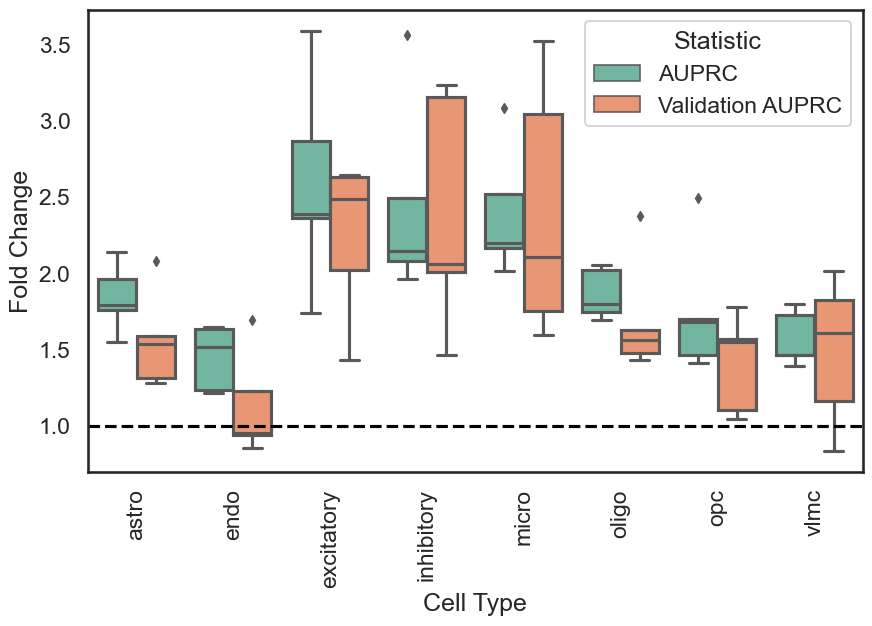

In [9]:
# Baseline
# TODO: Come up with better visualization for baseline
# than line, and update to all cell types
base_auprc = graph.y[graph.known_mask].float().mean()

# Create df
df = pd.DataFrame(stats)
df['AUPRC'] /= float(base_auprc); df['Validation AUPRC'] /= float(base_auprc)
df = df[['Cell Type', 'Fold'] + ['AUPRC', 'Validation AUPRC']]
df = df.melt(id_vars=['Cell Type', 'Fold'], value_name='Fold Change', var_name='Statistic')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.boxplot(data=df, x='Cell Type', y='Fold Change', hue='Statistic', ax=ax)
plt.axhline(y=1, color='black', ls='--')
# plt.ylim(0, 1)
plt.xticks(rotation=90)
fig.savefig(os.path.join(PLOTS_FOLDER, f'GCN_Performance_{group}_{disease}.pdf'))